In [3]:
import numpy as np
import math
from math import e
import pandas as pd
import qutip as qt
import random
from scipy.linalg import expm

In [4]:
# function for checking whether or not matrix is hermitian
def check_hermitian(A):
    Adag = A.getH()
    if not (np.array_equal(np.matmul(Adag,A),np.matmul(A,Adag))):
        return False
    return True

In [5]:
def generate_hermitian(a,b,c,d):
    return np.matrix([[a,c+d*1j],[c-d*1j,b]])

In [6]:
a=random.random()
b=random.random()
c=random.random()
d=random.random()
A = generate_hermitian(a,b,c,d)

In [7]:
# should always be true
check_hermitian(A)

True

In [8]:
# if A is identity, maybe try different values of alpha, beta, gamma, and delta
A

matrix([[0.30475373+0.j        , 0.9654315 +0.45008725j],
        [0.9654315 -0.45008725j, 0.07407364+0.j        ]])

In [9]:
# generate random 2 dimensional vector
vec = np.random.rand(2)

In [10]:
def get_magnitude(v):
    return math.sqrt(v[0]**2+v[1]**2)

In [11]:
# change vector to have norm of 1
vec = vec/get_magnitude(vec)

In [12]:
vec

array([0.03993531, 0.99920227])

In [13]:
'''
def evolve(v,A):
    return np.matmul(A,v).A1
'''

# v: inital state
# A: hamiltonian
# t: time-step of new state
def evolve(v,A,t):
    A = -A*1j*t
    A = expm(A)
    return np.matmul(A,v)

In [14]:
timestep = 7
evolve(vec,A,timestep)

array([-0.72441192-0.60113946j,  0.14531513-0.30453609j])

In [19]:
e1 = np.linalg.eigvals(A)[0]
e2 = np.linalg.eigvals(A)[1]
I = np.matrix([[1+0*1j,0+0*1j],[0+0*1j,1+0*1j]])
term1 = I*(e2*e**(-e1*1j*timestep)-e1*e**(-e2*1j*timestep))/(e2-e1)
term2 = A*(e**(-e2*1j*timestep)-e**(-e1*1j*timestep))/(e2-e1)

mat_exp = term1+term2 
np.matmul(mat_exp,vec)

matrix([[-0.72441192-0.60113946j,  0.14531513-0.30453609j]])

In [20]:
# v is the inital state as a complex vector with two dimensions
# A is the hamiltonian defining the evolution of the state
# n is the number of evolutions, the number of state vectors in the returned evolution_matrix
def generate_evolution_matrix(v,A,n):
    evolution_matrix = np.array([v,evolve(v,A,1)])
    for i in range(2,n):
        evolution_matrix = np.vstack( (evolution_matrix,np.array([evolve(v,A,i)])) )
    return evolution_matrix

In [21]:
num_rows = 100
evolution_matrix = generate_evolution_matrix(vec,A,num_rows)

split_evolution_matrix = np.zeros((evolution_matrix.shape[0],4))

#extract real and imaginary parts out of evolution matrix
for row in range(0,evolution_matrix.shape[0]):
    split_evolution_matrix[row, 0] = np.real(evolution_matrix[row, 0])
    split_evolution_matrix[row, 1] = np.imag(evolution_matrix[row, 0])
    split_evolution_matrix[row, 2] = np.real(evolution_matrix[row, 1])
    split_evolution_matrix[row, 3] = np.imag(evolution_matrix[row, 1])
    
# export evolution matrix as csv
mat_df = pd.DataFrame(split_evolution_matrix)
mat_df.to_csv("evolution_data.csv")

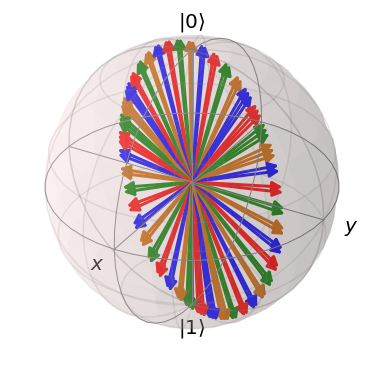

In [22]:
b = qt.Bloch()
state_matrix = np.empty(num_rows, dtype=qt.Qobj)
for i in range(0,num_rows):
    state_matrix[i] = qt.Qobj(evolution_matrix[i])

b.add_states(state_matrix)
b.render()

Hamiltonian:
 [[0.63195917+0.j         0.24614961+0.29920789j]
 [0.24614961-0.29920789j 0.73817501+0.j        ]]
Initial State:
 [0.88822522 0.45940826]


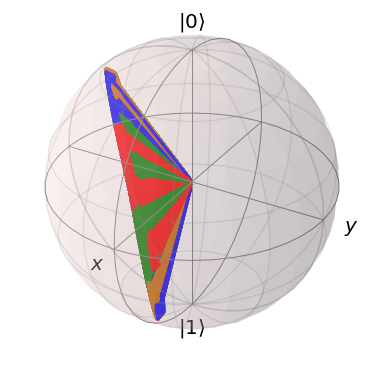

In [23]:
# choose random coefficients for hermitian hamiltonian
a=random.random()
b=random.random()
c=random.random()
d=random.random()
H = generate_hermitian(a,b,c,d)

# generate random 2 dimensional vector
vec = np.random.rand(2)

# change vector to have norm of 1
vec = vec/get_magnitude(vec)

# choose number of evolutions
num_rows = 1000
evolution_matrix = generate_evolution_matrix(vec,H,num_rows)

#extract real and imaginary parts out of evolution matrix
split_evolution_matrix = np.zeros((evolution_matrix.shape[0],4))
for row in range(0,evolution_matrix.shape[0]):
    split_evolution_matrix[row, 0] = np.real(evolution_matrix[row, 0])
    split_evolution_matrix[row, 1] = np.imag(evolution_matrix[row, 0])
    split_evolution_matrix[row, 2] = np.real(evolution_matrix[row, 1])
    split_evolution_matrix[row, 3] = np.imag(evolution_matrix[row, 1])
    
# export evolution matrix as csv
mat_df = pd.DataFrame(split_evolution_matrix)
mat_df.to_csv("evolution_data.csv")

#visualize on bloch sphere
b = qt.Bloch()
state_matrix = np.empty(num_rows, dtype=qt.Qobj)
for i in range(0,num_rows):
    state_matrix[i] = qt.Qobj(evolution_matrix[i])
b.add_states(state_matrix)
b.render()

# print hamiltonian and initial vector
print("Hamiltonian:\n",H)
print("Initial State:\n",vec)

In [24]:
def generate_data(filename,num_evolutions):
    # choose random coefficients for hermitian hamiltonian
    a=random.random()
    b=random.random()
    c=random.random()
    d=random.random()
    H = generate_hermitian(a,b,c,d)

    # generate random 2 dimensional vector
    vec = np.random.rand(2)

    # change vector to have norm of 1
    vec = vec/get_magnitude(vec)

    # choose number of evolutions
    num_rows = num_evolutions
    evolution_matrix = generate_evolution_matrix(vec,H,num_rows)

    #extract real and imaginary parts out of evolution matrix
    split_evolution_matrix = np.zeros((evolution_matrix.shape[0],4))
    for row in range(0,evolution_matrix.shape[0]):
        split_evolution_matrix[row, 0] = np.real(evolution_matrix[row, 0])
        split_evolution_matrix[row, 1] = np.imag(evolution_matrix[row, 0])
        split_evolution_matrix[row, 2] = np.real(evolution_matrix[row, 1])
        split_evolution_matrix[row, 3] = np.imag(evolution_matrix[row, 1])
    
    # export evolution matrix as csv
    mat_df = pd.DataFrame(split_evolution_matrix)
    mat_df.to_csv(filename)

In [ ]:
for i in range(1,31):
    filename = "data/evolution_data" + str(i) + ".csv"
    generate_data(filename,3000)